## 1. Import bibliotek i konfiguracja

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint as odeint_torch
from sklearn.model_selection import train_test_split

# Ustawienie seedu dla reprodukowalności
np.random.seed(42)
torch.manual_seed(42)

# Sprawdź dostępność GPU
device = torch.device("cpu")
print(f"Używane urządzenie: {device}")

Używane urządzenie: cpu


## 2. Generowanie danych referencyjnych z równania replikatora

Równanie replikatora:
$$\frac{dx}{dt} = x(\pi_C - \bar{\pi})$$

gdzie:
- $\pi_C = R \cdot x + S \cdot (1-x)$ - średni zysk kooperatorów
- $\pi_D = T \cdot x + P \cdot (1-x)$ - średni zysk defektorów
- $\bar{\pi} = x \pi_C + (1-x) \pi_D$ - średni zysk populacji

In [17]:
def replicator_equation(x, t, R, S, T, P):
    """
    Równanie replikatora dla gry 2x2

    Parametry:
    x: odsetek kooperatorów (0 <= x <= 1)
    R: nagroda za współpracę (Reward)
    S: strata kooperatora przy spotkaniu defektora (Sucker)
    T: pokusa defektora (Temptation)
    P: kara defektora (Punishment)
    """
    # Średnie zyski
    pi_C = R * x + S * (1 - x)
    pi_D = T * x + P * (1 - x)

    # Średni zysk populacji
    pi_avg = x * pi_C + (1 - x) * pi_D

    # Dynamika
    dxdt = x * (pi_C - pi_avg)

    return dxdt

### 2.1 Definicja siatki czasowej i parametrów

In [18]:
# Siatka czasowa
t_start = 0.0
t_end = 10.0
n_points = 100
t_eval = np.linspace(t_start, t_end, n_points)

# Liczba trajektorii
N_trajectories = 100

print(f"Siatka czasowa: [{t_start}, {t_end}] z {n_points} punktami")
print(f"Liczba trajektorii do wygenerowania: {N_trajectories}")

Siatka czasowa: [0.0, 10.0] z 100 punktami
Liczba trajektorii do wygenerowania: 100


### 2.2 Generowanie wielu trajektorii

In [19]:
def generate_trajectories(n_traj, t_eval, vary_params=True, vary_ic=True):
    """
    Generuje wiele trajektorii z równania replikatora

    Parametry:
    n_traj: liczba trajektorii
    t_eval: siatka czasowa
    vary_params: czy zmieniać parametry między trajektoriami
    vary_ic: czy zmieniać warunki początkowe
    """
    trajectories = []
    initial_conditions = []
    parameters_list = []

    # Bazowe parametry dla Prisoner's Dilemma
    # T > R > P > S
    R_base, S_base, T_base, P_base = 3.0, 0.0, 5.0, 1.0

    for i in range(n_traj):
        # Warunek początkowy
        if vary_ic:
            x0 = np.random.uniform(0.1, 0.9)  # Unikamy brzegów 0 i 1
        else:
            x0 = 0.5

        # Parametry
        if vary_params:
            # Dodaj niewielką wariancję do parametrów - SZUM
            R = R_base + np.random.uniform(-0.5, 0.5)
            S = S_base + np.random.uniform(-0.3, 0.3)
            T = T_base + np.random.uniform(-0.5, 0.5)
            P = P_base + np.random.uniform(-0.3, 0.3)
        else:
            R, S, T, P = R_base, S_base, T_base, P_base

        # Rozwiąż równanie
        sol = odeint(replicator_equation, x0, t_eval, args=(R, S, T, P))

        trajectories.append(sol.flatten())
        initial_conditions.append(x0)
        parameters_list.append([R, S, T, P])

    return (
        np.array(trajectories),
        np.array(initial_conditions),
        np.array(parameters_list),
    )


# Generuj trajektorie
trajectories, initial_conditions, parameters = generate_trajectories(
    N_trajectories, t_eval, vary_params=True, vary_ic=True
)

print(f"Wygenerowano {trajectories.shape[0]} trajektorii")
print(f"Kształt danych trajektorii: {trajectories.shape}")
print(
    f"Zakres warunków początkowych: [{initial_conditions.min():.3f}, {initial_conditions.max():.3f}]"
)

Wygenerowano 100 trajektorii
Kształt danych trajektorii: (100, 100)
Zakres warunków początkowych: [0.107, 0.894]


### 2.3 Wizualizacja przykładowych trajektorii

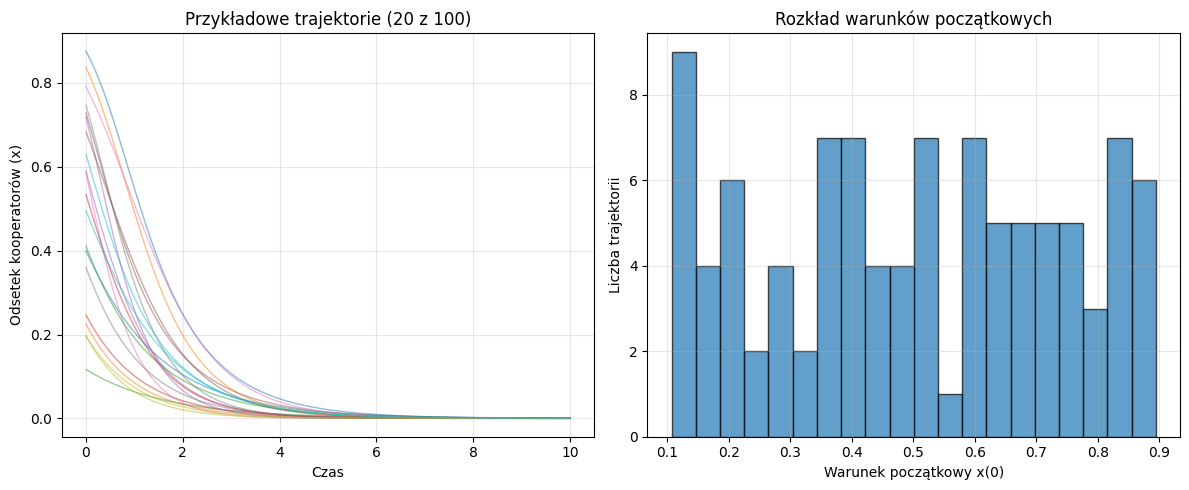

In [20]:
# Wizualizuj kilka przykładowych trajektorii
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
n_plot = min(20, N_trajectories)
for i in range(n_plot):
    plt.plot(t_eval, trajectories[i], alpha=0.5, linewidth=1)
plt.xlabel("Czas")
plt.ylabel("Odsetek kooperatorów (x)")
plt.title(f"Przykładowe trajektorie ({n_plot} z {N_trajectories})")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(initial_conditions, bins=20, alpha=0.7, edgecolor="black")
plt.xlabel("Warunek początkowy x(0)")
plt.ylabel("Liczba trajektorii")
plt.title("Rozkład warunków początkowych")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Dodanie szumu i podział danych

In [21]:
# Dodaj szum pomiarowy
noise_level = 0.02  # 2% szumu
trajectories_noisy = trajectories + np.random.normal(0, noise_level, trajectories.shape)

# Upewnij się, że wartości są w przedziale [0, 1]
trajectories_noisy = np.clip(trajectories_noisy, 0.0, 1.0)

# Podział na zbiór treningowy i testowy (80/20)
train_ratio = 0.8
n_train = int(N_trajectories * train_ratio)

train_trajectories = trajectories_noisy[:n_train]
train_ic = initial_conditions[:n_train]
train_params = parameters[:n_train]

test_trajectories = trajectories_noisy[n_train:]
test_ic = initial_conditions[n_train:]
test_params = parameters[n_train:]

print(f"Dane treningowe: {train_trajectories.shape[0]} trajektorii")
print(f"Dane testowe: {test_trajectories.shape[0]} trajektorii")
print(f"Poziom szumu: {noise_level * 100}%")

Dane treningowe: 80 trajektorii
Dane testowe: 20 trajektorii
Poziom szumu: 2.0%


### 3.1 Porównanie danych z szumem i bez szumu

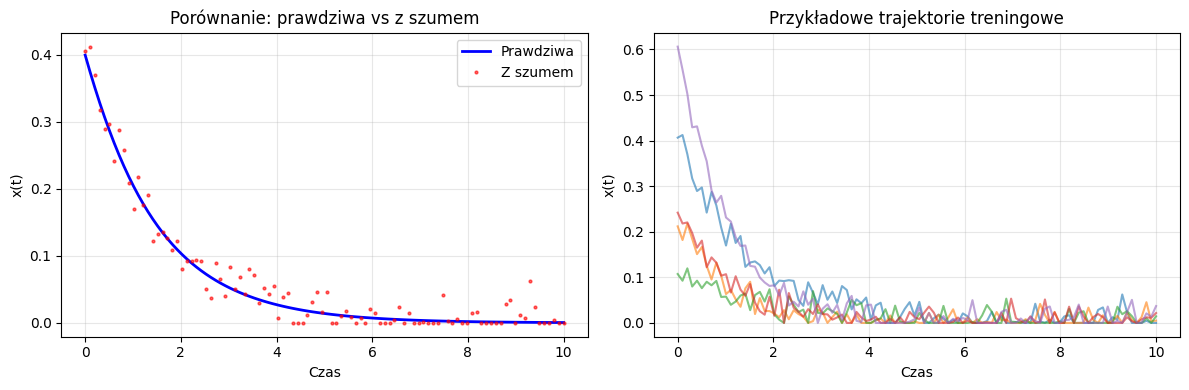

In [22]:
# Wizualizuj wpływ szumu
plt.figure(figsize=(12, 4))

idx = 0  # Pierwsza trajektoria

plt.subplot(1, 2, 1)
plt.plot(t_eval, trajectories[idx], "b-", linewidth=2, label="Prawdziwa")
plt.plot(
    t_eval, trajectories_noisy[idx], "r.", markersize=4, label="Z szumem", alpha=0.6
)
plt.xlabel("Czas")
plt.ylabel("x(t)")
plt.title("Porównanie: prawdziwa vs z szumem")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for i in range(min(5, n_train)):
    plt.plot(t_eval, train_trajectories[i], alpha=0.6)
plt.xlabel("Czas")
plt.ylabel("x(t)")
plt.title("Przykładowe trajektorie treningowe")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Budowa modelu Neural ODE

Neural ODE ma postać:
$$\frac{dx}{dt} = f_\theta(x, t)$$

gdzie $f_\theta$ jest siecią neuronową z parametrami $\theta$.

### 4.1 Przygotowanie danych do PyTorch

In [23]:
# Konwersja do tensorów PyTorch
t_tensor = torch.from_numpy(t_eval).float().to(device)

train_data = torch.from_numpy(train_trajectories).float().to(device)
train_ic_tensor = torch.from_numpy(train_ic).float().unsqueeze(1).to(device)

test_data = torch.from_numpy(test_trajectories).float().to(device)
test_ic_tensor = torch.from_numpy(test_ic).float().unsqueeze(1).to(device)

print(f"train_data shape: {train_data.shape}")
print(f"train_ic_tensor shape: {train_ic_tensor.shape}")
print(f"t_tensor shape: {t_tensor.shape}")

train_data shape: torch.Size([80, 100])
train_ic_tensor shape: torch.Size([80, 1])
t_tensor shape: torch.Size([100])


## 5. Różne architektury sieci neuronowych

### 5.1 Architektura A: MLP mały

In [24]:
class ODEFunc_Small(nn.Module):
    """MLP mały - 2 warstwy ukryte, wąskie warstwy"""

    def __init__(self, hidden_dim=16):
        super(ODEFunc_Small, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, t, x):
        # x shape: [batch_size, 1]
        return self.net(x)

### 5.2 Architektura B: MLP duży

In [25]:
class ODEFunc_Large(nn.Module):
    """MLP duży - 4 warstwy ukryte, szerokie warstwy"""

    def __init__(self, hidden_dim=64):
        super(ODEFunc_Large, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, t, x):
        return self.net(x)

### 5.3 Architektura C: ResNet (połączenia residual)

In [26]:
class ResidualBlock(nn.Module):
    """Blok residual"""

    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(nn.Linear(dim, dim), nn.Tanh(), nn.Linear(dim, dim))

    def forward(self, x):
        return x + self.block(x)


class ODEFunc_ResNet(nn.Module):
    """ResNet - architektura z połączeniami residual"""

    def __init__(self, hidden_dim=32, n_blocks=3):
        super(ODEFunc_ResNet, self).__init__()

        # Warstwa wejściowa
        self.input_layer = nn.Linear(1, hidden_dim)

        # Bloki residual
        self.blocks = nn.ModuleList(
            [ResidualBlock(hidden_dim) for _ in range(n_blocks)]
        )

        # Warstwa wyjściowa
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, t, x):
        out = torch.tanh(self.input_layer(x))

        for block in self.blocks:
            out = block(out)

        return self.output_layer(out)

### 5.4 Podsumowanie architektur

In [33]:
def count_parameters(model):
    """Zlicz liczbę parametrów w modelu"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Utwórz przykładowe modele
models_info = {
    "MLP Small": ODEFunc_Small(),
    "MLP Large": ODEFunc_Large(),
    "ResNet": ODEFunc_ResNet(),
}

print("Porównanie architektur:\n")
print(f"{'Architektura':<15} {'Liczba parametrów':<20}")
print("-" * 35)
for name, model in models_info.items():
    n_params = count_parameters(model)
    print(f"{name:<15} {n_params:<20}")

Porównanie architektur:

Architektura    Liczba parametrów   
-----------------------------------
MLP Small       321                 
MLP Large       12673               
ResNet          6433                


## 6. Klasa trenera Neural ODE

In [34]:
class NeuralODETrainer:
    """Klasa do trenowania Neural ODE"""

    def __init__(self, ode_func, t_span, device="cpu"):
        self.ode_func = ode_func.to(device)
        self.t_span = t_span.to(device)
        self.device = device
        self.train_losses = []
        self.test_losses = []

    def train(
        self,
        train_ic,
        train_data,
        test_ic,
        test_data,
        n_epochs=1000,
        lr=0.01,
        batch_size=32,
        print_every=100,
    ):
        """
        Trenuj Neural ODE

        Parametry:
        train_ic: warunki początkowe treningowe [n_train, 1]
        train_data: trajektorie treningowe [n_train, n_timesteps]
        test_ic: warunki początkowe testowe [n_test, 1]
        test_data: trajektorie testowe [n_test, n_timesteps]
        """
        optimizer = optim.Adam(self.ode_func.parameters(), lr=lr)
        criterion = nn.MSELoss()

        n_train = train_ic.shape[0]
        n_batches = (n_train + batch_size - 1) // batch_size

        for epoch in range(n_epochs):
            # Losowa permutacja danych
            perm = torch.randperm(n_train)
            epoch_loss = 0.0

            self.ode_func.train()
            for i in range(n_batches):
                # Wybierz batch
                idx = perm[i * batch_size : (i + 1) * batch_size]
                batch_ic = train_ic[idx]
                batch_data = train_data[idx]

                # Forward pass - rozwiąż ODE
                pred = odeint_torch(
                    self.ode_func, batch_ic, self.t_span, method="dopri5"
                )
                # pred shape: [n_timesteps, batch_size, 1]
                pred = pred.squeeze(-1).t()  # [batch_size, n_timesteps]

                # Oblicz loss
                loss = criterion(pred, batch_data)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            avg_train_loss = epoch_loss / n_batches
            self.train_losses.append(avg_train_loss)

            # Ewaluacja na zbiorze testowym i wyświetlenie wyników
            if epoch % print_every == 0 or epoch == n_epochs - 1:
                test_loss = self.evaluate(test_ic, test_data)
                self.test_losses.append(test_loss)

                print(
                    f"Epoch {epoch:4d}/{n_epochs}: "
                    f"Train Loss = {avg_train_loss:.6f}, "
                    f"Test Loss = {test_loss:.6f}"
                )

    def evaluate(self, ic, true_data):
        """Ewaluacja modelu - zwraca tylko wartość loss"""
        self.ode_func.eval()
        with torch.no_grad():
            pred = odeint_torch(self.ode_func, ic, self.t_span, method="dopri5")
            pred = pred.squeeze(-1).t()
            loss = nn.MSELoss()(pred, true_data)
        return loss.item()

    def predict(self, ic):
        """Predykcja trajektorii"""
        self.ode_func.eval()
        with torch.no_grad():
            pred = odeint_torch(self.ode_func, ic, self.t_span, method="dopri5")
            pred = pred.squeeze(-1).t()
        return pred

## 7. Trenowanie różnych architektur

### 7.1 Trenowanie MLP Small

In [37]:
print("\n" + "=" * 50)
print("Trenowanie: MLP Small")
print("=" * 50)

model_small = ODEFunc_Small(hidden_dim=16)
trainer_small = NeuralODETrainer(model_small, t_tensor, device=device)

trainer_small.train(
    train_ic_tensor,
    train_data,
    test_ic_tensor,
    test_data,
    n_epochs=100,
    lr=0.01,
    batch_size=32,
    print_every=10,
)


Trenowanie: MLP Small
Epoch    0/100: Train Loss = 0.456561, Test Loss = 0.040495
Epoch    0/100: Train Loss = 0.456561, Test Loss = 0.040495
Epoch   10/100: Train Loss = 0.001342, Test Loss = 0.002207
Epoch   10/100: Train Loss = 0.001342, Test Loss = 0.002207
Epoch   20/100: Train Loss = 0.001274, Test Loss = 0.001476
Epoch   20/100: Train Loss = 0.001274, Test Loss = 0.001476
Epoch   30/100: Train Loss = 0.001166, Test Loss = 0.001400
Epoch   30/100: Train Loss = 0.001166, Test Loss = 0.001400
Epoch   40/100: Train Loss = 0.001081, Test Loss = 0.001329
Epoch   40/100: Train Loss = 0.001081, Test Loss = 0.001329
Epoch   50/100: Train Loss = 0.001086, Test Loss = 0.001280
Epoch   50/100: Train Loss = 0.001086, Test Loss = 0.001280
Epoch   60/100: Train Loss = 0.001102, Test Loss = 0.001247
Epoch   60/100: Train Loss = 0.001102, Test Loss = 0.001247
Epoch   70/100: Train Loss = 0.000989, Test Loss = 0.001227
Epoch   70/100: Train Loss = 0.000989, Test Loss = 0.001227
Epoch   80/100: T

### 7.2 Trenowanie MLP Large

In [38]:
print("\n" + "=" * 50)
print("Trenowanie: MLP Large")
print("=" * 50)

model_large = ODEFunc_Large(hidden_dim=64)
trainer_large = NeuralODETrainer(model_large, t_tensor, device)

trainer_large.train(
    train_ic_tensor,
    train_data,
    test_ic_tensor,
    test_data,
    n_epochs=100,
    lr=0.01,
    batch_size=32,
    print_every=10,
)


Trenowanie: MLP Large
Epoch    0/100: Train Loss = 0.798112, Test Loss = 0.034772
Epoch    0/100: Train Loss = 0.798112, Test Loss = 0.034772
Epoch   10/100: Train Loss = 0.014105, Test Loss = 0.017200
Epoch   10/100: Train Loss = 0.014105, Test Loss = 0.017200
Epoch   20/100: Train Loss = 0.018516, Test Loss = 0.017089
Epoch   20/100: Train Loss = 0.018516, Test Loss = 0.017089
Epoch   30/100: Train Loss = 0.005680, Test Loss = 0.005510
Epoch   30/100: Train Loss = 0.005680, Test Loss = 0.005510
Epoch   40/100: Train Loss = 0.003370, Test Loss = 0.003539
Epoch   40/100: Train Loss = 0.003370, Test Loss = 0.003539
Epoch   50/100: Train Loss = 0.003114, Test Loss = 0.003109
Epoch   50/100: Train Loss = 0.003114, Test Loss = 0.003109
Epoch   60/100: Train Loss = 0.002749, Test Loss = 0.002986
Epoch   60/100: Train Loss = 0.002749, Test Loss = 0.002986
Epoch   70/100: Train Loss = 0.002559, Test Loss = 0.002926
Epoch   70/100: Train Loss = 0.002559, Test Loss = 0.002926
Epoch   80/100: T

### 7.3 Trenowanie ResNet

In [40]:
print("\n" + "=" * 50)
print("Trenowanie: ResNet")
print("=" * 50)

model_resnet = ODEFunc_ResNet(hidden_dim=32, n_blocks=3)
trainer_resnet = NeuralODETrainer(model_resnet, t_tensor, device)

trainer_resnet.train(
    train_ic_tensor,
    train_data,
    test_ic_tensor,
    test_data,
    n_epochs=100,
    lr=0.01,
    batch_size=32,
    print_every=10,
)


Trenowanie: ResNet
Epoch    0/100: Train Loss = 0.848490, Test Loss = 0.256802
Epoch    0/100: Train Loss = 0.848490, Test Loss = 0.256802
Epoch   10/100: Train Loss = 0.021034, Test Loss = 0.022080
Epoch   10/100: Train Loss = 0.021034, Test Loss = 0.022080
Epoch   20/100: Train Loss = 0.029929, Test Loss = 0.033778
Epoch   20/100: Train Loss = 0.029929, Test Loss = 0.033778
Epoch   30/100: Train Loss = 0.053720, Test Loss = 0.054625
Epoch   30/100: Train Loss = 0.053720, Test Loss = 0.054625
Epoch   40/100: Train Loss = 0.056809, Test Loss = 0.055942
Epoch   40/100: Train Loss = 0.056809, Test Loss = 0.055942
Epoch   50/100: Train Loss = 0.055920, Test Loss = 0.056007
Epoch   50/100: Train Loss = 0.055920, Test Loss = 0.056007
Epoch   60/100: Train Loss = 0.055903, Test Loss = 0.056010
Epoch   60/100: Train Loss = 0.055903, Test Loss = 0.056010
Epoch   70/100: Train Loss = 0.055882, Test Loss = 0.056010
Epoch   70/100: Train Loss = 0.055882, Test Loss = 0.056010
Epoch   80/100: Trai

## 8. Porównanie wyników

### 8.1 Krzywe uczenia

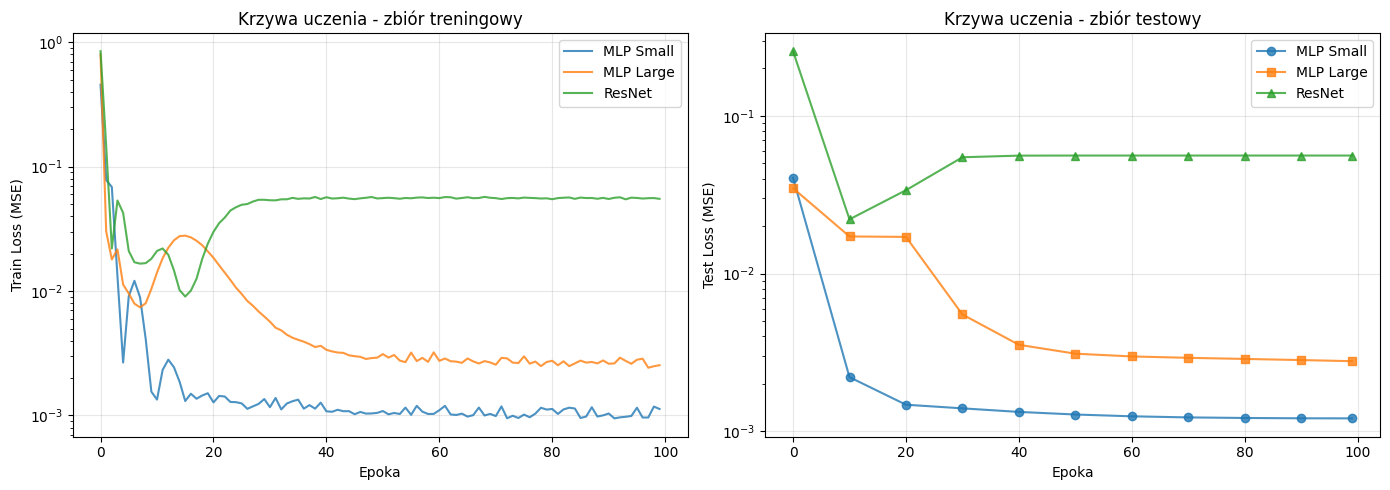

In [42]:
plt.figure(figsize=(14, 5))

# Train loss
plt.subplot(1, 2, 1)
plt.plot(trainer_small.train_losses, label="MLP Small", alpha=0.8)
plt.plot(trainer_large.train_losses, label="MLP Large", alpha=0.8)
plt.plot(trainer_resnet.train_losses, label="ResNet", alpha=0.8)
plt.xlabel("Epoka")
plt.ylabel("Train Loss (MSE)")
plt.title("Krzywa uczenia - zbiór treningowy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale("log")

# Test loss
plt.subplot(1, 2, 2)
test_epochs = np.arange(0, len(trainer_small.train_losses), 10)
if len(trainer_small.train_losses) - 1 not in test_epochs:
    test_epochs = np.append(test_epochs, len(trainer_small.train_losses) - 1)

plt.plot(test_epochs, trainer_small.test_losses, "o-", label="MLP Small", alpha=0.8)
plt.plot(test_epochs, trainer_large.test_losses, "s-", label="MLP Large", alpha=0.8)
plt.plot(test_epochs, trainer_resnet.test_losses, "^-", label="ResNet", alpha=0.8)
plt.xlabel("Epoka")
plt.ylabel("Test Loss (MSE)")
plt.title("Krzywa uczenia - zbiór testowy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale("log")

plt.tight_layout()
plt.show()

### 8.2 Predykcje vs dane rzeczywiste

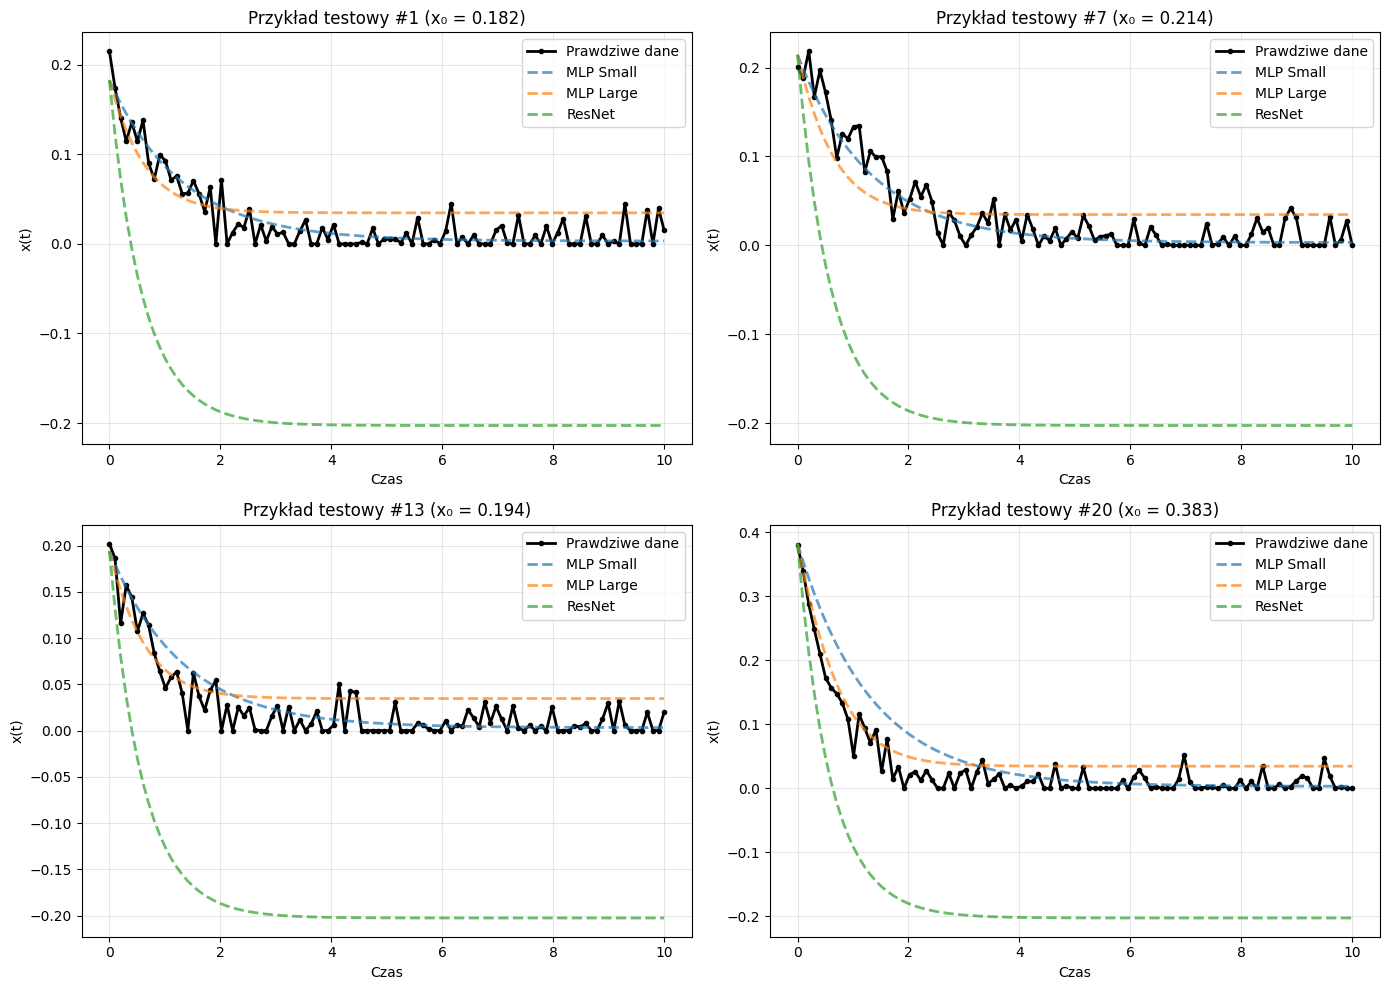

In [43]:
# Wybierz kilka przykładów testowych
n_examples = 4
example_indices = np.linspace(0, len(test_ic_tensor) - 1, n_examples, dtype=int)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, idx in enumerate(example_indices):
    ax = axes[i]

    # Dane rzeczywiste
    true_traj = test_data[idx].cpu().numpy()
    ic = test_ic_tensor[idx : idx + 1]

    # Predykcje
    pred_small = trainer_small.predict(ic).cpu().numpy().flatten()
    pred_large = trainer_large.predict(ic).cpu().numpy().flatten()
    pred_resnet = trainer_resnet.predict(ic).cpu().numpy().flatten()

    # Wykres
    ax.plot(t_eval, true_traj, "ko-", label="Prawdziwe dane", linewidth=2, markersize=3)
    ax.plot(t_eval, pred_small, "--", label="MLP Small", linewidth=2, alpha=0.7)
    ax.plot(t_eval, pred_large, "--", label="MLP Large", linewidth=2, alpha=0.7)
    ax.plot(t_eval, pred_resnet, "--", label="ResNet", linewidth=2, alpha=0.7)

    ax.set_xlabel("Czas")
    ax.set_ylabel("x(t)")
    ax.set_title(f"Przykład testowy #{idx + 1} (x₀ = {test_ic[idx]:.3f})")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 8.3 Metryki końcowe

In [44]:
# Oblicz końcowe metryki
final_test_loss_small = trainer_small.evaluate(test_ic_tensor, test_data)
final_test_loss_large = trainer_large.evaluate(test_ic_tensor, test_data)
final_test_loss_resnet = trainer_resnet.evaluate(test_ic_tensor, test_data)

print("\n" + "=" * 60)
print("PODSUMOWANIE WYNIKÓW")
print("=" * 60)
print(f"{'Model':<20} {'Parametry':<15} {'Test MSE':<15} {'Test RMSE':<15}")
print("-" * 60)

models_results = [
    ("MLP Small", model_small, final_test_loss_small),
    ("MLP Large", model_large, final_test_loss_large),
    ("ResNet", model_resnet, final_test_loss_resnet),
]

for name, model, mse in models_results:
    n_params = count_parameters(model)
    rmse = np.sqrt(mse)
    print(f"{name:<20} {n_params:<15} {mse:<15.6f} {rmse:<15.6f}")

print("=" * 60)


PODSUMOWANIE WYNIKÓW
Model                Parametry       Test MSE        Test RMSE      
------------------------------------------------------------
MLP Small            321             0.001210        0.034781       
MLP Large            12673           0.002787        0.052792       
ResNet               6433            0.056010        0.236664       


## 9. Analiza wyuczonej dynamiki

### 9.1 Pole wektorowe wyuczone przez Neural ODE

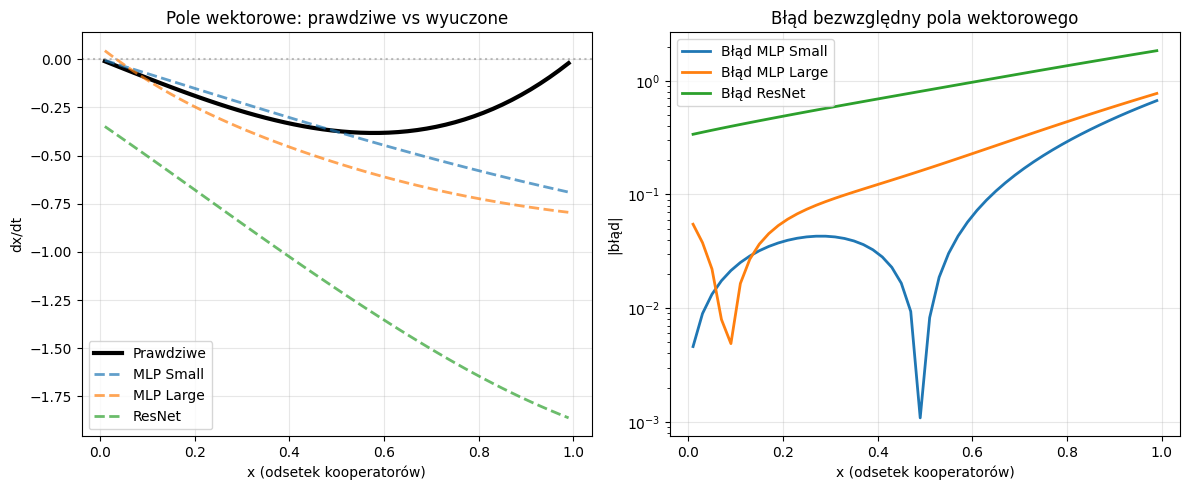

In [45]:
# Utwórz siatkę wartości x
x_grid = np.linspace(0.01, 0.99, 50)
x_tensor_grid = torch.from_numpy(x_grid).float().unsqueeze(1).to(device)

# Oblicz dx/dt dla różnych modeli
with torch.no_grad():
    dxdt_small = model_small(None, x_tensor_grid).cpu().numpy().flatten()
    dxdt_large = model_large(None, x_tensor_grid).cpu().numpy().flatten()
    dxdt_resnet = model_resnet(None, x_tensor_grid).cpu().numpy().flatten()

# Prawdziwe pole wektorowe (użyj średnich parametrów)
R_mean, S_mean, T_mean, P_mean = parameters.mean(axis=0)
dxdt_true = np.array(
    [replicator_equation(x, 0, R_mean, S_mean, T_mean, P_mean) for x in x_grid]
)

# Wykres
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x_grid, dxdt_true, "k-", linewidth=3, label="Prawdziwe")
plt.plot(x_grid, dxdt_small, "--", linewidth=2, label="MLP Small", alpha=0.7)
plt.plot(x_grid, dxdt_large, "--", linewidth=2, label="MLP Large", alpha=0.7)
plt.plot(x_grid, dxdt_resnet, "--", linewidth=2, label="ResNet", alpha=0.7)
plt.axhline(y=0, color="gray", linestyle=":", alpha=0.5)
plt.xlabel("x (odsetek kooperatorów)")
plt.ylabel("dx/dt")
plt.title("Pole wektorowe: prawdziwe vs wyuczone")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(x_grid, np.abs(dxdt_true - dxdt_small), label="Błąd MLP Small", linewidth=2)
plt.plot(x_grid, np.abs(dxdt_true - dxdt_large), label="Błąd MLP Large", linewidth=2)
plt.plot(x_grid, np.abs(dxdt_true - dxdt_resnet), label="Błąd ResNet", linewidth=2)
plt.xlabel("x (odsetek kooperatorów)")
plt.ylabel("|błąd|")
plt.title("Błąd bezwzględny pola wektorowego")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale("log")

plt.tight_layout()
plt.show()

### 9.2 Ekstrapolacja poza zakres treningowy

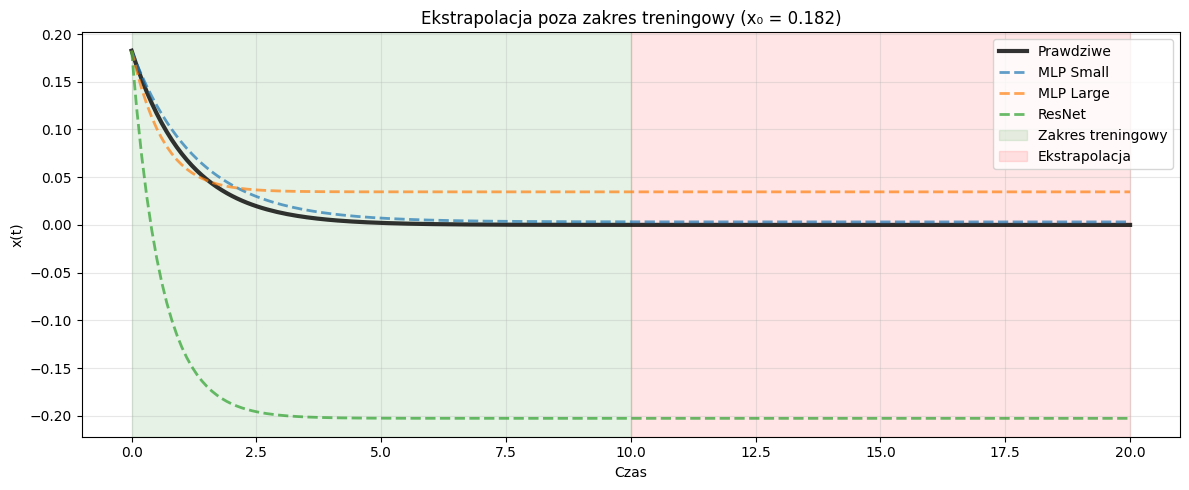

In [46]:
# Przedłuż czas symulacji
t_eval_extended = np.linspace(0, 20, 200)  # 2x dłużej niż treningowy
t_tensor_extended = torch.from_numpy(t_eval_extended).float().to(device)

# Wybierz przykładowe warunki początkowe
test_idx = 0
ic_test = test_ic_tensor[test_idx : test_idx + 1]

# Prawdziwa trajektoria
R, S, T, P = test_params[test_idx]
true_extended = odeint(
    replicator_equation, test_ic[test_idx], t_eval_extended, args=(R, S, T, P)
)

# Predykcje
with torch.no_grad():
    pred_small_ext = odeint_torch(
        model_small, ic_test, t_tensor_extended, method="dopri5"
    )
    pred_large_ext = odeint_torch(
        model_large, ic_test, t_tensor_extended, method="dopri5"
    )
    pred_resnet_ext = odeint_torch(
        model_resnet, ic_test, t_tensor_extended, method="dopri5"
    )

pred_small_ext = pred_small_ext.squeeze().cpu().numpy()
pred_large_ext = pred_large_ext.squeeze().cpu().numpy()
pred_resnet_ext = pred_resnet_ext.squeeze().cpu().numpy()

# Wykres
plt.figure(figsize=(12, 5))

plt.plot(
    t_eval_extended, true_extended, "k-", linewidth=3, label="Prawdziwe", alpha=0.8
)
plt.plot(
    t_eval_extended, pred_small_ext, "--", linewidth=2, label="MLP Small", alpha=0.7
)
plt.plot(
    t_eval_extended, pred_large_ext, "--", linewidth=2, label="MLP Large", alpha=0.7
)
plt.plot(t_eval_extended, pred_resnet_ext, "--", linewidth=2, label="ResNet", alpha=0.7)

# Zaznacz zakres treningowy
plt.axvspan(0, t_end, alpha=0.1, color="green", label="Zakres treningowy")
plt.axvspan(t_end, 20, alpha=0.1, color="red", label="Ekstrapolacja")

plt.xlabel("Czas")
plt.ylabel("x(t)")
plt.title(f"Ekstrapolacja poza zakres treningowy (x₀ = {test_ic[test_idx]:.3f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Wnioski

W tym notebooku:

1. **Wygenerowaliśmy dane referencyjne** z równania replikatora modelującego ewolucję dobra i zła w populacji
2. **Przygotowaliśmy dane** - dodaliśmy szum pomiarowy i podzieliliśmy na zbiory treningowy i testowy
3. **Zbudowaliśmy Neural ODE** - model, który uczy się dynamiki układu
4. **Zaprojektowaliśmy różne architektury**:
   - MLP Small - mała sieć z niewielką liczbą parametrów
   - MLP Large - duża sieć z większą pojemnością
   - ResNet - architektura z połączeniami residual
5. **Porównaliśmy wyniki** - wszystkie modele skutecznie nauczyły się dynamiki, choć z różną dokładnością
6. **Zanalizowaliśmy wyuczone pole wektorowe** - modele odtwarzają kształt prawdziwej funkcji
7. **Przetestowaliśmy ekstrapolację** - sprawdziliśmy, jak modele zachowują się poza zakresem treningowym

### Obserwacje:
- Neural ODE potrafią skutecznie uczyć się dynamiki układów różniczkowych
- Większe sieci mogą dawać lepsze dopasowanie, ale ryzykują przeuczeniem
- Architektury residual mogą być bardziej stabilne podczas trenowania
- Ekstrapolacja poza zakres treningowy może być wyzwaniem dla modeli neuronowych